# Capstone Project

### Jiewei Chen

April 2017

***
## Comment Analysis Part

### 90000 games! 32 features! Up to 100 text comments for each game!

***

In this part the comments under different rating categories are analyzed.

The comments are tokenized into lemma, and the lemma with high frequency was stored as the corpus of a specific rate level. Then number of shared word (called common words later) between two different levels is computed. The percentages of shared word within a level are presented in a heatmap to see the difference.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
com = pd.read_csv('comments.csv')
com.head()

bins = list(range(2,11,2))
com['rate_cat'] = pd.cut(com.rating, bins=bins, labels=bins[1:])
print(com.shape)
for i in com.index:
    if type(com.loc[i,'comment']) != str:
        com = com.drop(i)
com.head()
print(com.shape)

(67593, 5)
(67591, 5)


In [3]:
# slice the comments based on the rating

# rating 0-2
rate2 = com[com.rate_cat == 2] # this one is empty
rate2
# rating 2-4
rate4 = com[com.rate_cat == 4]
# rating 4-6
rate6 = com[com.rate_cat == 6]
# rating 6-8
rate8 = com[com.rate_cat == 8]
# rating 8-10
rate10 = com[com.rate_cat == 10]

In [4]:
stemmer = PorterStemmer().stem

tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

In [5]:
stop = set(stopwords.words('english'))

def diction(files):
    """
    Returns a dictionary from lemmata to document ids containing that lemma
    Input is a data frame
    Output is a dictionary with lemmata as key and document ids as values
    """
    textd = {} 
    for i in files.index:
        # loop over each raw text
        t = files.loc[i,'comment']
        # return unique and order list of words appeared in the raw text
        try:
            s = set(lemmatize(t))- stop - set(string.punctuation)
        except IndexError:
            s = set()
        try:
            toks = toks | s   # append to "toks" set a "s"
        except NameError:
            toks = s    # if doesn't exsit, initialize it
        for tok in s:
            try:
                textd[tok].append(i)
            except KeyError:
                textd[tok] = [i]
    
    return textd
            

In [6]:
def top_words(rate_df): 
    """
    This funtion takes the a data frame which contains the documents id and the corresponding text
    returns a dataframe of words and #of documents containing that word
    the data frame is sorted
    """
    textd = diction(rate_df[['Unnamed: 0','comment']])
    textnum = {key:len(set(val)) for key,val in textd.items()}
    sor = [(key, textnum[key]) for key in sorted(textnum, key=lambda x : textnum[x], reverse=True)]
    df_sorted = pd.DataFrame(sor)
    df_sorted.columns = ['word', '# of documents']
    df_sorted['percent'] = df_sorted['# of documents']/df_sorted.shape[0]
    
    return df_sorted

df_sorted_4 = top_words(rate4)
df_sorted_6 = top_words(rate6)
df_sorted_8 = top_words(rate8)
df_sorted_10 = top_words(rate10)

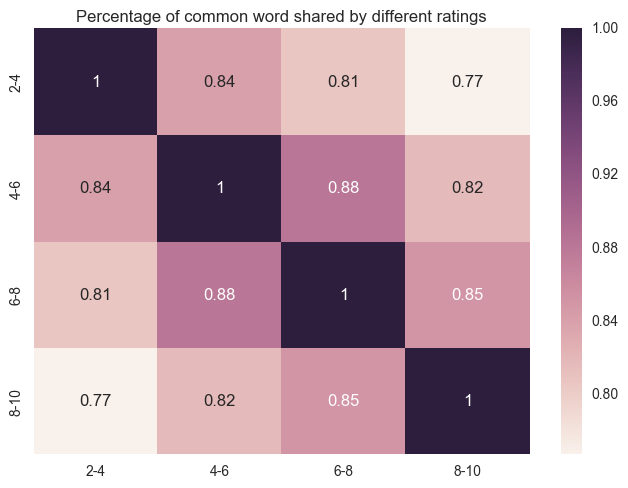

In [12]:
# top n words in each rating category is considered.
n = 2000
words_4 = set(df_sorted_4.loc[:n,'word'].values)
words_6 = set(df_sorted_6.loc[:n,'word'].values)
words_8 = set(df_sorted_8.loc[:n,'word'].values)
words_10 = set(df_sorted_10.loc[:n,'word'].values)

shared_words_46 = words_4.intersection(words_6)
shared_words_48 = words_4.intersection(words_8)
shared_words_410 = words_4.intersection(words_10)
shared_words_68 = words_6.intersection(words_8)
shared_words_610 = words_6.intersection(words_10)
shared_words_810 = words_8.intersection(words_10)

shared_words = shared_words_46.intersection(shared_words_810)

sim = np.array([[1,len(shared_words_46) / len(words_4), len(shared_words_48) / len(words_4), len(shared_words_410) / len(words_4)],
          [len(shared_words_46) / len(words_6),1, len(shared_words_68) / len(words_6), len(shared_words_610) / len(words_6)],
          [len(shared_words_48) / len(words_8),len(shared_words_68) / len(words_8),1, len(shared_words_810) / len(words_8)],
          [len(shared_words_410) / len(words_10), len(shared_words_610) / len(words_10), len(shared_words_810) / len(words_10),1]]) * 100

import seaborn as sns
sns.heatmap(sim, annot=True,xticklabels = ['2-4','4-6','6-8','8-10'],yticklabels = ['2-4','4-6','6-8','8-10'])
plt.title('Percentage of common word shared by different ratings')

# plt.savefig('commonwordmatrix.png')
plt.show()

From this graph, it can be observed that, the closer the two level are, the more common words shared by these two.

For example, look at the first row, which represents the percent of shared words of level 2-4 in the corpus of level 2-4, with respect to other levels. As the rating gets higher, the percentage drops, indicating that the comments are getting more and more different as the rating score getting higher.

This first exploration definitely gives us confidence that the commets under different rating scores are different. Thus, it is reasonable to come up with a prediction algorithm based on these comments.
***
Below is word cloud showing what people are expressing in the commenst.

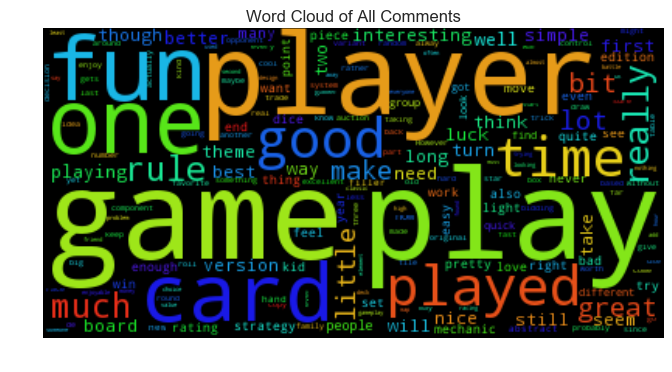

In [13]:
wc_text = "".join(list(com.loc[:,'comment']))
wordcloud = WordCloud(max_font_size=80).generate(wc_text)
plt.figure(figsize = (8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud of All Comments")

# plt.savefig('wordcloud.png')
plt.show()